In [ ]:
import kutils
from kutils.model_helper import ModelHelper
from kutils import applications as apps
from kutils import image_utils as iu
from kutils import tensor_ops as ops
from kutils import generic as gen
import resnet101

import pandas as pd
import keras
import numpy as np
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras import backend as K

### Initialize dataset meta

In [2]:
aux_root = '/mnt/home/research/data/'
data_root = '/mnt/home/research/koniq/'
ids = pd.read_csv(data_root + 'metadata/koniq10k_distributions_sets.csv')

# define 5 classes
mos_class = np.int32(ids.MOS/20.)
ids.loc[:,'class'] = mos_class
x = keras.utils.to_categorical(mos_class)
classes = pd.DataFrame(x.tolist())
output_classes = ['class0', 'class1', 'class2', 'class3', 'class4']
classes.columns = output_classes
ids = pd.concat([ids, classes], axis=1, verify_integrity=True)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(mos_class),
                                                  mos_class)

### DeepRN base model 
224x224 crops from 1024x768 + rotation and horizontal flips

In [ ]:
input_shape = (224,224,3)
loss = categorical_crossentropy
data_path = data_root + 'images/1024x768'
model_name = 'DeepRN'

model = resnet101.resnet101_model(input_shape  = input_shape,
                                  weights_root = 'cnn_finetune/imagenet_models', 
                                  include_top  = True,
                                  num_classes  = 5)
pre = resnet101.preprocess_input_resnet101

# the performance is higher without the rotation augmentation
process_fn = lambda im: pre(iu.ImageAugmenter(im, remap=False).crop((224,224)).fliplr().rotate(5).result)

gen_params = dict(batch_size    = 64, 
                  data_path     = data_path, 
                  fixed_batches = True,
                  input_shape   = input_shape, 
                  process_fn    = process_fn,
                  outputs       = output_classes)

helper = ModelHelper(model, model_name, ids, verbose = False,
                     loss         = categorical_crossentropy, 
                     optimizer    = keras.optimizers.SGD(lr       = 0.01, 
                                                         momentum = 0.9, 
                                                         decay    = 5e-4),
                     metrics        = ["MAE",'accuracy'], 
                     monitor_metric = 'val_loss', monitor_mode = 'min',
                     early_stop_patience = 20, 
                     class_weights       = class_weights,
                     multiproc    = True, workers = 3,
                     logs_root    = aux_root  + 'logs/koniq', 
                     models_root  = data_root + 'models/', 
                     gen_params   = gen_params)

helper.set_trainable(index=81)
print 'First trainable layer:', helper.model.layers[81].name
print 'Model name:', helper.model_name()

In [ ]:
# x,_ = helper.test_generator()
# iu.view_stack(gen.mapmm(x[0]), figsize=(5,5))

In [ ]:
LR = 0.0001 # initial
for i in range(3):
    print 'Iteration', i
    print 'LR =', LR
    helper.train(lr=LR, epochs=100)
    LR /= 10

In [ ]:
helper.load_model()
valid_gen = helper.make_generator(ids[ids.set=='validation'],
                                  deterministic=True)
print 'Accuracy:', helper.model.evaluate_generator(valid_gen)[2]
apps.test_rating_model(helper, groups=1);

### Change model to extract features
* Huber-loss
* allow any resolution input
* only horizontal flip augmentation

In [ ]:
input_shape = (768,1024,3)
loss = K.tf.losses.huber_loss
data_path = data_root + 'images/1024x768/'

model = resnet101.resnet101_model(input_shape  = (None, None, 3),
                                  weights_root = 'cnn_finetune/imagenet_models', 
                                  include_top  = False,
                                  num_classes  = 5)
pre = resnet101.preprocess_input_resnet101
process_fn = lambda im: pre(iu.ImageAugmenter(im).fliplr().result)

gen_params = dict(batch_size    = 2, 
                  data_path     = data_path, 
                  fixed_batches = True,
                  input_shape   = input_shape, 
                  process_fn    = process_fn,
                  inputs        = 'image_name',
                  outputs       = ('c1','c2','c3','c4','c5'))

helper = ModelHelper(model, model_name, ids,
                     verbose      = True,                     
                     logs_root    = aux_root  + 'logs/koniq', 
                     models_root  = data_root + 'models/',                     
                     features_root= data_root + 'features/',                     
                     gen_params   = gen_params)

name = 'DeepRN/bsz64_i1[224,224,3]_lcategori_o1[5]'
helper.load_model(name, by_name=True)

In [ ]:
# x,_ = helper.test_generator()
# iu.view_stack(gen.mapmm(x[0]))

### Change model head from GAP to SPP
(for feature extraction)

In [ ]:
from layers.SpatialPyramidPooling import SpatialPyramidPooling

# helper.model.summary()
gap_input = helper.model.layers[-2].output
feats = SpatialPyramidPooling([3], name='SPP')(gap_input)
model_spp = Model(inputs=helper.model.input, outputs=feats)
helper.model = model_spp

In [ ]:
helper.save_activations(ids=ids, verbose=True, output_layer='SPP', 
                        groups=2, over_write=True)

### Train on features

In [4]:
input_shape = (768,1024)
input_size = 2048 * 9

features_path = data_root + 'features/DeepRN/i1[768,1024,3]_lSPP_o1[2048]_r2.h5'
fc1_size = 4096
input_feats = keras.layers.Input(shape=(input_size,), dtype='float32')

# works better if NOT normalizing the features
# norm_feats = Lambda(lambda  x: K.tf.nn.l2_normalize(x,1))(input_feats)

pred = apps.fc_layers(input_feats, 
                     name          = 'main',
                     fc_sizes      = [4096,4096,4096, 5], 
                     dropout_rates = [0.5, 0.5, 0.5,  0],
                     batch_norm    = 0,
                     out_activation = 'softmax')

model = keras.models.Model(inputs=input_feats, outputs=pred)

root_name = 'DeepRN_final'

gen_params = dict(batch_size  = 128, 
                  data_path   = features_path,
                  process_fn  = None, 
                  input_shape = (input_size,),
                  inputs      = ('image_name',), 
                  outputs     = ('c1','c2','c3','c4','c5'), 
                  random_group= True)

loss = ops.make_loss(K.tf.losses.huber_loss, delta=1./9)
# works better if using the Huber loss with default delta=1
# loss = K.tf.losses.huber_loss

helper = ModelHelper(model, root_name, ids, 
                     loss = loss,
                     optimizer = keras.optimizers.SGD(lr       = 0.001, 
                                                momentum = 0.9, 
                                                decay    = 4e-4),                     
                     metrics=['MAE'], 
                     monitor_metric='val_loss', monitor_mode='min', 
                     early_stop_patience = 20, workers = 10,
                     logs_root  = aux_root+'/logs/koniq',
                     models_root= data_root+'/models',
                     gen_params =gen_params)

helper.model_name.update(imsz=list(input_shape))
print helper.model_name()

DeepRN_final/bsz128_i1[18432]_imsz[768, 1024]_lcustom_l_o1[5]


In [ ]:
LR = 0.01
for i in range(4):
    print 'Iteration', i
    print 'LR =', LR
    helper.train(lr=LR, epochs=200)
    LR /= 10

Model weights loaded: DeepRN_final/bsz128_i1[18432]_imsz[768, 1024]_lcustom_l_o1[5]_best_weights.h5
Testing model
Model outputs: ['main_out']

Evaluated on test-set
SRCC/PLCC: 0.87 0.88


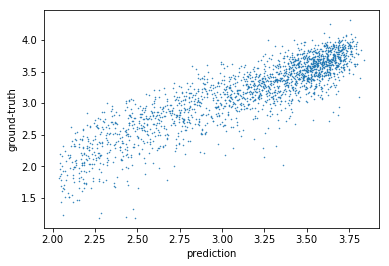

In [5]:
helper.load_model()
apps.test_rating_model(helper, groups=2);